## Gluon Pilot for Donkey car with early stopping and lr decay

@author: Sunil Mallya

In [2]:
def linear_bin(a):
    a = a + 1
    b = round(a / (2./14))
    return int(b)

def linear_unbin(arr):
    b = np.argmax(arr)
    a = b *(2./14) - 1
    return a

In [3]:
import numpy as np
from PIL import Image
import os

PATH = 'trainingdata/'
image_paths = os.listdir(PATH)

images = []
a_labels = []
t_labels = []
for image_path in image_paths:
    f = PATH + image_path
    parts = f.split('ttl_')[1].split('_')
    ttl = float(parts[0])
    agl = float(parts[2])
    
    img = np.array(Image.open(f)) #.resize((120, 160), Image.BILINEAR))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    images.append(img)
    a_labels.append(linear_bin(agl))
    t_labels.append(ttl)

np_images = np.stack(images).astype('float32')
a_labels = np.stack(a_labels) #.astype('float32')
t_labels = np.stack(t_labels).astype('float32')

In [4]:
np_images.shape

(12800, 3, 120, 160)

In [5]:
a_labels.shape


(12800,)

In [76]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
mx.random.seed(1)

class BaseCNNClassifier(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseCNNClassifier, self).__init__()
        self.ctx = ctx
        self.net = None
        self.loss_vals = []
        self.train_acc = []
        self.val_acc = []
        
    #@override
    def build_model(self, convs, num_fc, num_classes):
        '''
        Default activation is relu
        '''
        # convs = [(channel, kernel_sz, pool_siz)triplets *N]
        net = gluon.nn.HybridSequential(prefix='')
        with net.name_scope():
            for ch, k_sz, p_sz in convs:
                net.add(gluon.nn.Conv2D(channels=ch, kernel_size=k_sz, activation='relu'))
                net.add(gluon.nn.MaxPool2D(pool_size=p_sz, strides=2)) # strides fixed for now
            
            #net = gluon.nn.HybridSequential()
            #net.add(cnn_layers)
            
            # Flatten and apply fully connected layers
            net.add(gluon.nn.Flatten())
            net.add(gluon.nn.Dense(num_fc, activation="relu"))
            net.add(gluon.nn.Dense(num_classes))

        # speed up execution with hybridization
        net.hybridize()
        self.net = net
    
    def predict(self, batch):
        nd_imgs = mx.nd.array(batch)
        ctx_nd_imgs = nd_imgs.as_in_context(ctx)
        output = self.net(ctx_nd_imgs)
        return nd.argmax(output, axis=1).asnumpy()

    def compile_model(self, loss=None, optimizer='sgd', lr=1E-3, init_mg=2.24):
        self.net.collect_params().initialize(mx.init.Xavier(magnitude=init_mg), ctx=self.ctx)
        self.loss = gluon.loss.SoftmaxCrossEntropyLoss() if loss is None else loss
        self.optimizer = mx.gluon.Trainer(self.net.collect_params(), 
                                          optimizer, {'learning_rate': lr})
    
    def evaluate_accuracy(self, data_iterator):
        acc = mx.metric.Accuracy()
        for i, (data, label) in enumerate(data_iterator):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = self.net(data)
            predictions = nd.argmax(output, axis=1)
            acc.update(preds=predictions, labels=label)
        return acc.get()[1]
    
    def fit(self, train_data, test_data, epochs):
        
        smoothing_constant = .01
        ctx = self.ctx
        
        for e in range(epochs):
            for i, (data, label) in enumerate(train_data):
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                #print data.shape, label.shape
                with autograd.record(train_mode=True):
                    output = self.net(data)
                    loss = self.loss(output, label)
                loss.backward()
                self.optimizer.step(data.shape[0])

                curr_loss = nd.mean(loss).asscalar()
                moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

            test_accuracy = self.evaluate_accuracy(test_data)
            train_accuracy = self.evaluate_accuracy(train_data)
            print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
            self.loss_vals.append(moving_loss)
            self.train_acc.append(train_accuracy)
            self.val_acc.append(test_accuracy)
        return self.loss_vals, self.train_acc, self.val_acc

    def save(self, filename='mynet.params'):
        self.net.save_params(filename)
        
    def load(self, filename):
        self.net.load_params(filename, ctx=self.ctx)

In [ ]:
'''
@author: Sunil Mallya
'''
### Donkey Gluon Pilot

import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
mx.random.seed(1)

class BaseCNNClassifier(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseCNNClassifier, self).__init__()
        self.ctx = ctx
        self.net = None
        self.loss_vals = []
        self.train_acc = []
        self.val_acc = []
        
    #@override
    def build_model(self, convs, num_fc, num_classes):
        '''
        Default activation is relu
        '''
        # convs = [(channel, kernel_sz, pool_siz)triplets *N]
        net = gluon.nn.HybridSequential(prefix='')
        with net.name_scope():
            for ch, k_sz, p_sz in convs:
                net.add(gluon.nn.Conv2D(channels=ch, kernel_size=k_sz, activation='relu'))
                net.add(gluon.nn.MaxPool2D(pool_size=p_sz, strides=2)) # strides fixed for now
            
            #net = gluon.nn.HybridSequential()
            #net.add(cnn_layers)
            
            # Flatten and apply fully connected layers
            net.add(gluon.nn.Flatten())
            net.add(gluon.nn.Dense(num_fc, activation="relu"))
            net.add(gluon.nn.Dense(num_classes))

        # speed up execution with hybridization
        net.hybridize()
        self.net = net
    
    def predict(self, batch):
        nd_imgs = mx.nd.array(batch)
        ctx_nd_imgs = nd_imgs.as_in_context(ctx)
        output = self.net(ctx_nd_imgs)
        return nd.argmax(output, axis=1).asnumpy()

    def compile_model(self, loss=None, optimizer='sgd', lr=1E-3, init_mg=2.24):
        self.net.collect_params().initialize(mx.init.Xavier(magnitude=init_mg), ctx=self.ctx)
        self.loss = gluon.loss.SoftmaxCrossEntropyLoss() if loss is None else loss
        self.optimizer = mx.gluon.Trainer(self.net.collect_params(), 
                                          optimizer, {'learning_rate': lr})
    
    def evaluate_accuracy(self, data_iterator):
        acc = mx.metric.Accuracy()
        for i, (data, label) in enumerate(data_iterator):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = self.net(data)
            predictions = nd.argmax(output, axis=1)
            acc.update(preds=predictions, labels=label)
        return acc.get()[1]
    
    def fit(self, train_data, test_data, epochs):
        
        smoothing_constant = .01
        ctx = self.ctx
        
        for e in range(epochs):
            for i, (data, label) in enumerate(train_data):
                data = data.as_in_context(ctx)
                label = label.as_in_context(ctx)
                #print data.shape, label.shape
                with autograd.record(train_mode=True):
                    output = self.net(data)
                    loss = self.loss(output, label)
                loss.backward()
                self.optimizer.step(data.shape[0])

                curr_loss = nd.mean(loss).asscalar()
                moving_loss = (curr_loss if ((i == 0) and (e == 0)) 
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

            test_accuracy = self.evaluate_accuracy(test_data)
            train_accuracy = self.evaluate_accuracy(train_data)
            print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))
            self.loss_vals.append(moving_loss)
            self.train_acc.append(train_accuracy)
            self.val_acc.append(test_accuracy)
        return self.loss_vals, self.train_acc, self.val_acc

    def save(self, filename='mynet.params'):
        self.net.save_params(filename)
        
    def load(self, filename):
        self.net.load_params(filename, ctx=self.ctx)

class MXNetPilot():
    def load(self, model_path):
        pass
    
    def train(self, train_iter, val_iter, 
              saved_model_path, num_epoch=100, steps=100, train_split=0.8,
              verbose=1, min_delta=.0005, patience=5, use_early_stop=True):
        loss_vals, train_acc, val_acc = self.model.fit(train_iter, val_iter, epochs=25)
        return (loss_vals, train_acc, val_acc)     
        
    def get_train_val_iter(self, train_df, val_df, batch_size):
        train_iter = getIter(train_df, batch_size)
        val_iter = getIter(val_df, batch_size)
        return train_iter, val_iter
        
class GluonCategorical(MXNetPilot):
    def __init__(self, model=None, num_outputs=None, *args, **kwargs):
        super(GluonCategorical, self).__init__(*args, **kwargs)
        if model:
            self.model = model
        else:
            self.model = default_gluon_categorical()
    
    def run(self, img_arr):
        print(img_arr.shape)
        img_arr = np.swapaxes(img_arr, 0, 2)
        img_arr = np.swapaxes(img_arr, 1, 2)
        img_arr = img_arr.reshape((1,) + img_arr.shape)
        outputs = self.mode.predict([img_arr])
        angle_unbinned = dk.utils.linear_unbin(outputs)
        throttle = 0.25 #constant #multi output not implemented
        return angle_unbinned, throttle

## Bin helpers    
def linear_bin(a):
    a = a + 1
    b = round(a / (2./14))
    return int(b)

def linear_unbin(arr):
    b = np.argmax(arr)
    a = b *(2./14) - 1
    return a


# iterator
def getIter(df, batch):
    images = []
    a_labels = []
    t_labels = []

    for index, row in df.iterrows():
        img = np.array(Image.open(row['cam/image_array'])) #.resize((120, 160), Image.BILINEAR))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        images.append(img)
        a_labels.append(linear_bin(row['user/angle']) #categorical
        t_labels.append(row['user/throttle'])

    np_images = np.stack(images).astype('float32')
    a_labels = np.stack(a_labels)
    t_labels = np.stack(t_labels).astype('float32')

    #return mx.io.NDArrayIter({'data': np_images}, {'angle': a_labels, 'throttle': t_labels}, batch_size=batch)
    return mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(np_images, a_labels),
                                                batch_size=batch, shuffle=True)
def default_mxnet_linear():
    num_fc = 64
    num_classes = 15 #num of categories
    convs = [(24,5,2), (32,5,2), (64,5,2)]

    ctx = mx.gpu()
    cnn = BaseCNNClassifier(ctx)
    cnn.build_model(convs, num_fc, num_classes)
    cnn.compile_model(optimizer='adam')
    #print cnn.net.collect_params()
    return cnn

In [53]:
batch_size = 64

train_split = int(np_images.shape[0] *0.8)
X_train, X_test = np_images[:train_split], np_images[train_split:]
y_train, y_test = a_labels[:train_split], a_labels[train_split:]

print X_train.shape, y_train.shape
train_data = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X_train, y_train),
                                                batch_size=batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X_test, y_test),
                                                batch_size=batch_size, shuffle=True)

(10240, 3, 120, 160) (10240,)


In [68]:
num_fc = 64
num_classes = 15 #num_outputs
convs = [(24,5,2), (32,5,2), (64,5,2)]

ctx = mx.gpu()
cnn = BaseCNNClassifier(ctx)
cnn.build_model(convs, num_fc, num_classes)
cnn.compile_model(optimizer='adam')
print cnn.net.collect_params()

loss_vals, train_acc, val_acc = cnn.fit(train_data, test_data, epochs=25)

(
  Parameter conv0_weight (shape=(24L, 0L, 5L, 5L), dtype=<type 'numpy.float32'>)
  Parameter conv0_bias (shape=(24L,), dtype=<type 'numpy.float32'>)
  Parameter conv1_weight (shape=(32L, 0L, 5L, 5L), dtype=<type 'numpy.float32'>)
  Parameter conv1_bias (shape=(32L,), dtype=<type 'numpy.float32'>)
  Parameter conv2_weight (shape=(64L, 0L, 5L, 5L), dtype=<type 'numpy.float32'>)
  Parameter conv2_bias (shape=(64L,), dtype=<type 'numpy.float32'>)
  Parameter dense0_weight (shape=(64, 0), dtype=<type 'numpy.float32'>)
  Parameter dense0_bias (shape=(64,), dtype=<type 'numpy.float32'>)
  Parameter dense1_weight (shape=(15, 0), dtype=<type 'numpy.float32'>)
  Parameter dense1_bias (shape=(15,), dtype=<type 'numpy.float32'>)
)
Epoch 0. Loss: 4.42938834554, Train_acc 0.51875, Test_acc 0.501171875
Epoch 1. Loss: 1.94297836731, Train_acc 0.54755859375, Test_acc 0.524609375
Epoch 2. Loss: 1.3538606905, Train_acc 0.59345703125, Test_acc 0.532421875
Epoch 3. Loss: 1.16194418151, Train_acc 0.638769

In [57]:
cnn.save()

In [47]:
cnn.net.collect_params().save('mynet.params')

In [77]:
num_fc = 64
num_classes = 15 #num_outputs
convs = [(24,5,2), (32,5,2), (64,5,2)]

ctx = mx.gpu()
cnn = BaseCNNClassifier(ctx)
cnn.build_model(convs, num_fc, num_classes)
cnn.compile_model(optimizer='adam')
cnn.load('mynet.params')

In [78]:
cnn.predict(np_images[5:10])

array([ 4.,  7.,  7.,  7.,  7.], dtype=float32)

In [69]:
agl = cnn.predict([np_images[21]])
agl, a_labels[21]

(5.0, 5)

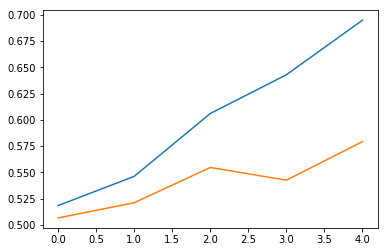

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_acc)
plt.plot(val_acc)

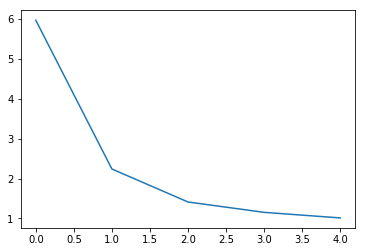

In [39]:
plt.plot(loss_vals)
